<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/Part_of_Speech_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will demonstrate Part-of-Speech (POS) tagging, a fundamental task in natural language processing (NLP). Part-of-Speech tagging involves assigning grammatical labels, or parts-of-speech, to each word in a given sentence or text. These parts-of-speech include nouns, verbs, adjectives, adverbs, pronouns, conjunctions, and more. POS tagging is crucial for various NLP applications, such as syntactic analysis, information extraction, and machine translation.

In [1]:
#Geting Dataset
import nltk
from nltk.corpus import brown

In [2]:
#download
nltk.download("brown")
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
corpus = brown.tagged_sents(tagset='universal')
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [4]:
input = list()
target = list()
for sentence in corpus:
  tokens = []
  taget = []
  for token, tag in sentence:
    tokens.append(token)
    taget.append(tag)
  input.append(tokens)
  target.append(taget)

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [6]:
# Get training and test sets
train_inputs, test_inputs, train_target, test_target = train_test_split(input, target, test_size = 0.3, random_state=42)

In [7]:
#convert sentences into sequence
MAX_VOCAB_SIZE = None
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,
                      lower=False,
                    oov_token= 'UNK')

In [8]:
tokenizer.fit_on_texts(train_inputs)
train_inputs_int = tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = tokenizer.texts_to_sequences(test_inputs)


In [9]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
V

47617

In [10]:
#Function to flatten list
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [11]:
all_train_targets = set(flatten(train_target))
all_train_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [12]:
#verification step
all_test_targets = set(flatten(test_target))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [13]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_target)
train_targets_int = tag_tokenizer.texts_to_sequences(train_target)
test_targets_int = tag_tokenizer.texts_to_sequences(test_target)

In [14]:
# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [15]:
#padd sequences
max_len_train = max(len(x) for x in train_inputs)
max_len_test = max(len(x) for x in test_inputs)
T = max((max_len_train, max_len_test))
T

180

In [16]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (40138, 180)


In [17]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (17202, 180)


In [18]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (40138, 180)


In [19]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (17202, 180)


In [20]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

In [21]:
# Create the model

# We get to choose embedding dimensionality
D = 50

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)
model = Model(i,x)


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 embedding (Embedding)       (None, 180, 50)           2380900   
                                                                 
 bidirectional (Bidirectiona  (None, 180, 64)          21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 180, 13)           845       
                                                                 
Total params: 2,402,993
Trainable params: 2,402,993
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)
print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5
1255/1255 [==============================] - 222s 172ms/step - loss: 0.4307 - accuracy: 0.8720 - val_loss: 0.1087 - val_accuracy: 0.9665
Epoch 2/5
1255/1255 [==============================] - 206s 164ms/step - loss: 0.0658 - accuracy: 0.9794 - val_loss: 0.0914 - val_accuracy: 0.9716
Epoch 3/5
1255/1255 [==============================] - 221s 176ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0894 - val_accuracy: 0.9730
Epoch 4/5
1255/1255 [==============================] - 212s 169ms/step - loss: 0.0292 - accuracy: 0.9906 - val_loss: 0.0944 - val_accuracy: 0.9728
Epoch 5/5
1255/1255 [==============================] - 213s 170ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.1011 - val_accuracy: 0.9724


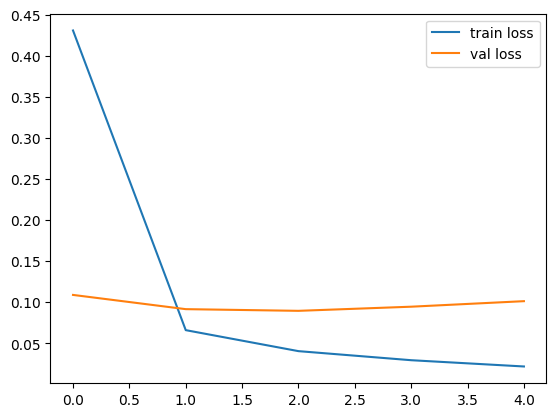

In [24]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

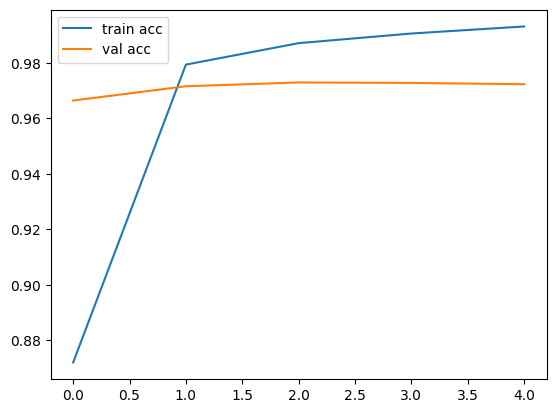

In [25]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();